# Approach 1: Exploratory Data Analysis and Model Training

## Input requirements: file master_data.json


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt

import glob
import os
from statsbombpy import sb

In [10]:
import matplotlib
matplotlib.__version__

'3.5.3'

In [11]:
!pip install --upgrade matplotlib --user

## EDA
First step is to load the json with all features 

In [12]:
master_data = pd.read_json('master_data.json')
master_data = master_data.dropna()
print(master_data.columns)
master_data.info()

Index(['index', 'period', 'timestamp', 'minute', 'location', 'pass_length',
       'pass_height', 'pass_switch', 'under_pressure', 'pass_cross',
       'pass_through_ball', 'binary_pass_risk', 'binary_pass_reward',
       'br_pressure', 'one_touch_pass', 'pass_from_duel', 'carry_dist',
       'carry_speed', 'pass_degree', 'pass_angle_cat', 'pass_receipt_loc',
       'passer_degree_to_goal', 'br_degree_to_goal', 'pass_loc_x',
       'pass_loc_y', 'pass_receipt_loc_x', 'pass_receipt_loc_y', 'deadball',
       'time_since_poss', 'from_keeper_held', 'pass_body_part_gr',
       'pc_5ft_actor_oppo', 'pc_oppo_closer_to_goal_passer',
       'oppo_min_dist_passer', 'min_degree_diff_passer_oppo',
       'closest_oppo_degree_diff_passer', 'pc_5ft_br_oppo',
       'pc_oppo_closer_to_goal_br', 'oppo_min_dist_br',
       'min_degree_diff_br_oppo', 'closest_oppo_degree_diff_br',
       'min_dist_from_br_teammate', 'pass_cut_back'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 47

In [13]:
master_data[['binary_pass_risk', 'binary_pass_reward']].sum()

binary_pass_risk      39838
binary_pass_reward     5313
dtype: int64

### View description for all features:
- This is to discover any data discrepancy or outliers

In [14]:
with pd.option_context('display.max_columns', None):
    display(master_data.describe())

,index,period,minute,pass_length,pass_switch,under_pressure,pass_cross,pass_through_ball,binary_pass_risk,binary_pass_reward,br_pressure,one_touch_pass,pass_from_duel,carry_dist,carry_speed,pass_degree,passer_degree_to_goal,br_degree_to_goal,pass_loc_x,pass_loc_y,pass_receipt_loc_x,pass_receipt_loc_y,deadball,time_since_poss,from_keeper_held,pc_5ft_actor_oppo,pc_oppo_closer_to_goal_passer,oppo_min_dist_passer,min_degree_diff_passer_oppo,closest_oppo_degree_diff_passer,pc_5ft_br_oppo,pc_oppo_closer_to_goal_br,oppo_min_dist_br,min_degree_diff_br_oppo,closest_oppo_degree_diff_br,min_dist_from_br_teammate,pass_cut_back
count,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.00000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000,47539.000000
mean,1915.484528,1.576558,47.300385,20.361148,0.028482,0.14973,0.021372,0.006710,0.838007,0.111761,0.071815,0.211195,0.017922,3.931000,3.034917,0.949248,0.342035,0.339257,59.626254,39.721397,64.422520,39.682221,0.045373,33.468312,0.005259,0.093067,0.863260,5.907883,84.862828,101.305486,0.023695,0.695020,13.085572,74.538638,-1.348889,8.575620,0.001977
std,1158.366571,0.662395,29.458175,13.201251,0.166347,0.35681,0.144622,0.081642,0.368449,0.315075,0.258184,0.408161,0.132670,6.128996,11.612786,91.533955,28.593993,29.423443,26.133979,23.668963,26.691683,23.439384,0.208124,182.207629,0.072328,0.103460,0.191160,4.985041,81.022148,46.209722,0.064166,0.348159,8.916436,59.201610,118.887133,8.855054,0.044424
min,5.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-179.723207,-90.000000,-90.000000,0.600000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000284,0.000284,0.000000,0.000000,0.033874,0.003475,-179.999619,0.000000,0.000000
25%,930.000000,1.000000,22.000000,11.298452,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-72.973575,-18.876117,-20.619853,41.300000,19.100000,45.300000,19.200000,0.000000,5.270500,0.000000,0.000000,0.777778,2.597387,32.087605,67.318395,0.000000,0.444444,6.727502,27.585073,-118.098980,3.110498,0.000000
50%,1863.000000,2.000000,46.000000,17.029387,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.486607,1.342494,0.000000,0.400663,0.543587,60.300000,39.500000,64.200000,39.500000,0.000000,14.679000,0.000000,0.100000,1.000000,4.433330,67.220382,106.130977,0.000000,0.833333,11.307409,76.240194,-2.663152,5.501090,0.000000
75%,2827.000000,2.000000,71.000000,25.600780,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.470832,3.640618,76.334548,19.627909,21.314171,78.300000,60.300000,84.400000,60.100000,0.000000,30.288500,0.000000,0.142857,1.000000,7.712030,109.981243,139.145992,0.000000,1.000000,17.260782,105.811580,116.409594,10.385498,0.000000
max,4963.000000,4.000000,124.000000,108.811770,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.522097,1002.237323,180.000000,90.000000,90.000000,120.000000,80.000000,120.000000,80.000000,1.000000,3082.659000,1.000000,1.000000,1.000000,54.840156,360.000000,179.985256,1.000000,2.000000,97.190252,360.000000,179.997274,96.857214,1.000000


#### Data error: Time since possession

- Due to source data error, sometimes time_since_possession can be as long as the whole duration of a half. Therefore, in order to remove these irregular rows, we will find a cut-off point from the normal data and remove everything greater than that by drawing a box-plot. Looking at the boxplot, we can determine our cut-off point to be around 250 seconds (over 4 minutes). After removing all the irregular data, we found that the actual longest possesion time is around 195 seconds (just over 3 minutes), closer to the expected value.

<AxesSubplot:>

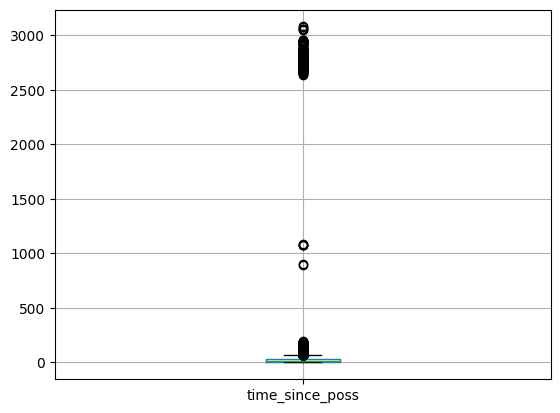

In [15]:
master_data.boxplot(['time_since_poss'])

In [16]:
master_data = master_data.loc[master_data['time_since_poss']<=250]

<AxesSubplot:>

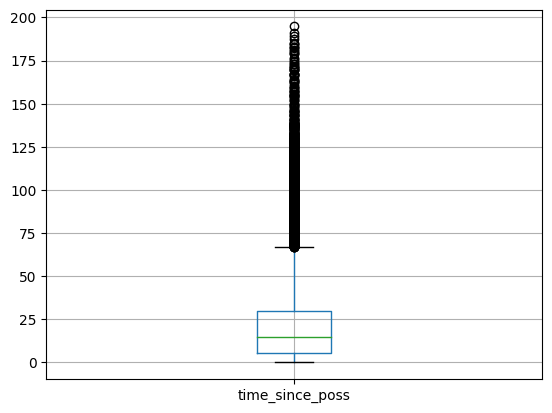

In [17]:
display(master_data.boxplot(['time_since_poss']))

### An example to view relations between target and predictors
- We hypothise that pass length have a negative impact on a pass's probability of completion, so we run a boxplot to view that.

<AxesSubplot:title={'center':'pass_length'}, xlabel='binary_pass_risk'>

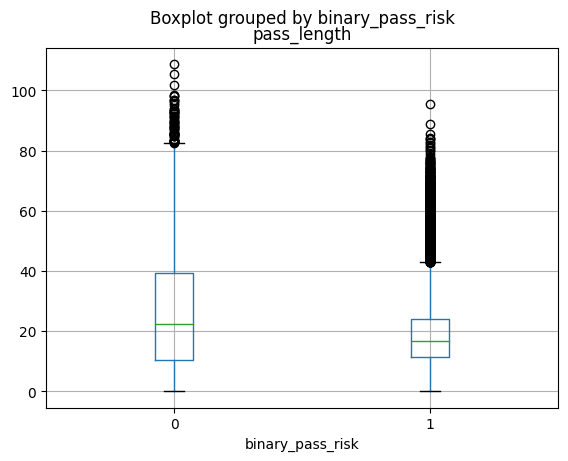

In [18]:
display(master_data.boxplot(['pass_length'], by='binary_pass_risk'))

### Correlation matrix
- Now we prepare the data set for our correlation matrices. We are doing separate correlation matrices for event features and tracking features since these two types of features have different nature.

In [19]:
#new df with only features to be included in final models
all_features = master_data.drop(['index', 'period', 'timestamp', 'location', 'pass_receipt_loc'], axis=1)

#get a list of all tracking features because we are doing separate correlation matrices for event features and tracking features
tracking_features = ['pc_5ft_actor_oppo', 'pc_oppo_closer_to_goal_passer',
       'oppo_min_dist_passer', 'min_degree_diff_passer_oppo',
       'closest_oppo_degree_diff_passer', 'pc_5ft_br_oppo',
       'pc_oppo_closer_to_goal_br', 'oppo_min_dist_br',
       'min_degree_diff_br_oppo', 'closest_oppo_degree_diff_br',
       'min_dist_from_br_teammate']
labels = ['binary_pass_risk', 'binary_pass_reward']

In [20]:
all_features.shape

(47329, 38)

In [21]:
with pd.option_context('display.max_columns', None):
    display(all_features.describe())

,minute,pass_length,pass_switch,under_pressure,pass_cross,pass_through_ball,binary_pass_risk,binary_pass_reward,br_pressure,one_touch_pass,pass_from_duel,carry_dist,carry_speed,pass_degree,passer_degree_to_goal,br_degree_to_goal,pass_loc_x,pass_loc_y,pass_receipt_loc_x,pass_receipt_loc_y,deadball,time_since_poss,from_keeper_held,pc_5ft_actor_oppo,pc_oppo_closer_to_goal_passer,oppo_min_dist_passer,min_degree_diff_passer_oppo,closest_oppo_degree_diff_passer,pc_5ft_br_oppo,pc_oppo_closer_to_goal_br,oppo_min_dist_br,min_degree_diff_br_oppo,closest_oppo_degree_diff_br,min_dist_from_br_teammate,pass_cut_back
count,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000,47329.000000
mean,47.271905,20.356782,0.028397,0.149929,0.021403,0.006740,0.837922,0.112172,0.071838,0.211012,0.017896,3.934205,3.040325,0.957447,0.333171,0.321764,59.637432,39.724359,64.436842,39.686296,0.045215,21.516065,0.005261,0.093109,0.863150,5.902251,84.853596,101.332517,0.023724,0.694700,13.080719,74.518712,-1.327287,8.575570,0.001986
std,29.492851,13.194507,0.166106,0.357006,0.144726,0.081822,0.368526,0.315582,0.258221,0.408031,0.132575,6.132646,11.637030,91.512859,28.599884,29.427682,26.142677,23.668008,26.704643,23.436994,0.207778,22.904427,0.072343,0.103455,0.191216,4.973412,80.985990,46.204131,0.064199,0.348201,8.917216,59.269411,118.859482,8.854614,0.044522
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-179.723207,-90.000000,-90.000000,0.600000,0.100000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000284,0.000284,0.000000,0.000000,0.033874,0.003475,-179.999619,0.000000,0.000000
25%,22.000000,11.296903,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-72.897271,-18.890069,-20.656443,41.300000,19.100000,45.300000,19.200000,0.000000,5.238000,0.000000,0.000000,0.777778,2.595545,32.102708,67.366597,0.000000,0.444444,6.717922,27.536044,-118.027920,3.111580,0.000000
50%,46.000000,17.029387,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.486607,1.344787,0.000000,0.396962,0.541971,60.400000,39.500000,64.200000,39.500000,0.000000,14.566000,0.000000,0.100000,1.000000,4.430132,67.227626,106.186786,0.000000,0.833333,11.296429,76.205769,-2.641784,5.500314,0.000000
75%,71.000000,25.600780,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.470832,3.642428,76.309945,19.623822,21.309311,78.300000,60.300000,84.400000,60.100000,0.000000,29.997000,0.000000,0.142857,1.000000,7.705532,110.016535,139.154980,0.000000,1.000000,17.256718,105.788960,116.406788,10.386046,0.000000
max,124.000000,108.811770,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.522097,1002.237323,180.000000,90.000000,90.000000,120.000000,80.000000,120.000000,80.000000,1.000000,194.813000,1.000000,1.000000,1.000000,54.840156,360.000000,179.985256,1.000000,2.000000,97.190252,360.000000,179.997274,96.857214,1.000000


#### Event features correlation matrix: 
- only y location of the pass, y location of the ball receipt and the angle of the passer/ball receiver to the goal has high correlation with each other (as expected). Angle to goal will be dropped for the risk model, and for the reward model ball receipt location will be dropped as well (because it is very highly correlated to whether it is received in the box)

<AxesSubplot:>

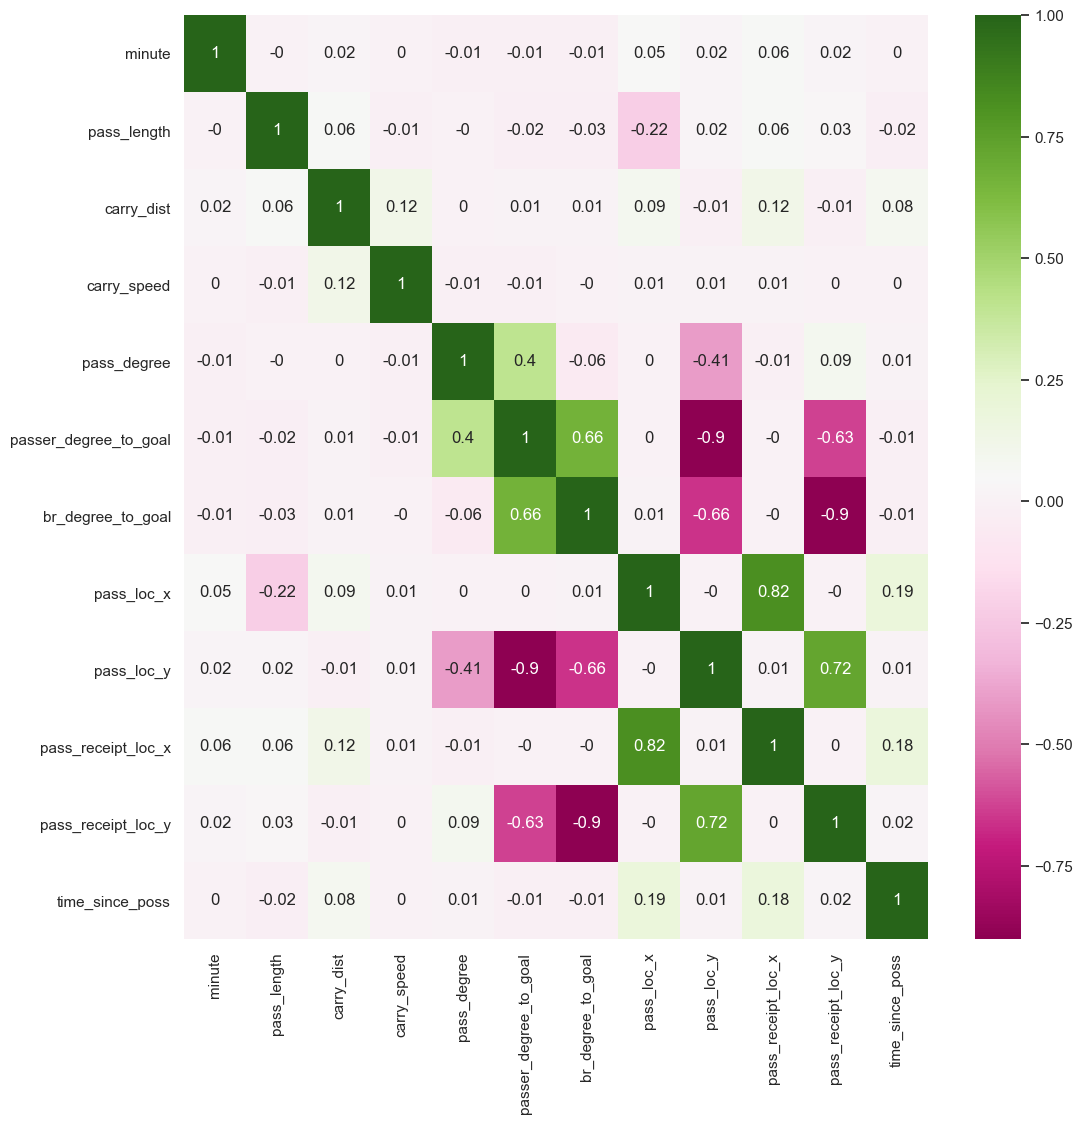

In [22]:
conti_event_features = ['minute', 'pass_length', 'carry_dist', 'carry_speed', 'pass_degree', 'passer_degree_to_goal',
                       'br_degree_to_goal', 'pass_loc_x','pass_loc_y', 'pass_receipt_loc_x', 'pass_receipt_loc_y',
                       'time_since_poss']

event_corr_matrix = all_features[conti_event_features].corr().round(2)

sn.set(rc={'figure.figsize':(12,12)})

sn.heatmap(event_corr_matrix, annot=True, cmap="PiYG")

<AxesSubplot:>

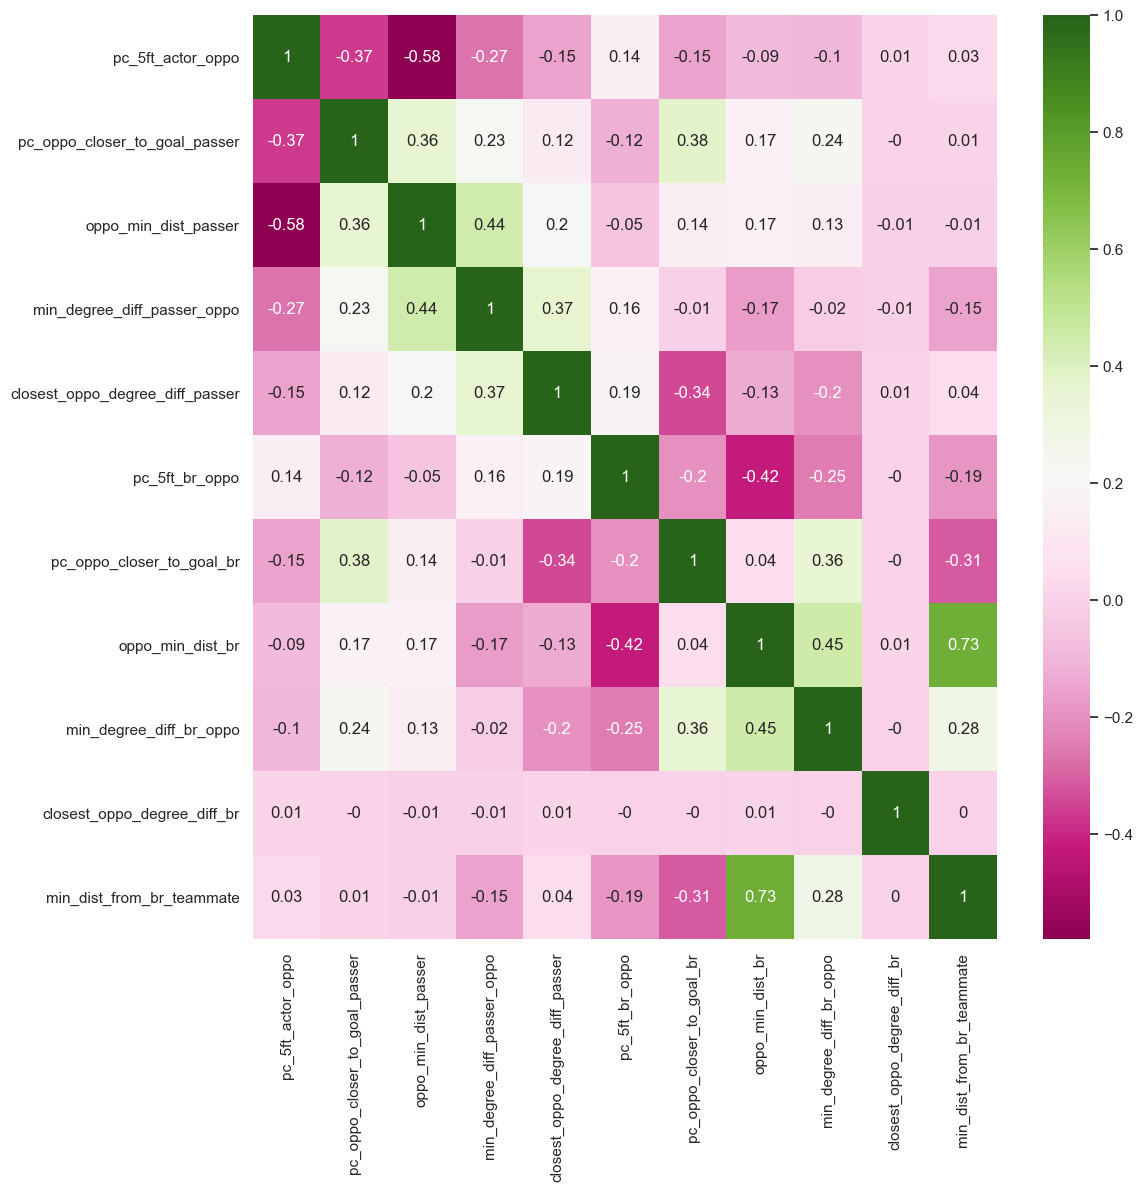

In [23]:
conti_tracking_features = [ 'pc_5ft_actor_oppo', 'pc_oppo_closer_to_goal_passer','oppo_min_dist_passer', 
                       'min_degree_diff_passer_oppo','closest_oppo_degree_diff_passer', 'pc_5ft_br_oppo',
                       'pc_oppo_closer_to_goal_br', 'oppo_min_dist_br','min_degree_diff_br_oppo', 'closest_oppo_degree_diff_br',
                       'min_dist_from_br_teammate']

tracking_corr_matrix = all_features[conti_tracking_features].corr().round(2)

sn.set(rc={'figure.figsize':(12,12)})

sn.heatmap(tracking_corr_matrix, annot=True, cmap="PiYG")

## Training

Onehot Encoding categorical data:



In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

ohe = make_column_transformer(
    (OneHotEncoder(), ['pass_height', 'pass_angle_cat', 'pass_body_part_gr']),
    remainder='passthrough', verbose_feature_names_out=False)



transformed = ohe.fit_transform(all_features)

transformed = pd.DataFrame(transformed, 
    columns=ohe.get_feature_names_out(), index = all_features.index
)

feature_names = ohe.get_feature_names_out()

transformed

,pass_height_Ground Pass,pass_height_High Pass,pass_height_Low Pass,pass_angle_cat_Backward,pass_angle_cat_Forward,pass_angle_cat_Sideways,pass_body_part_gr_Foot,pass_body_part_gr_Head,pass_body_part_gr_Other,minute,...,oppo_min_dist_passer,min_degree_diff_passer_oppo,closest_oppo_degree_diff_passer,pc_5ft_br_oppo,pc_oppo_closer_to_goal_br,oppo_min_dist_br,min_degree_diff_br_oppo,closest_oppo_degree_diff_br,min_dist_from_br_teammate,pass_cut_back
bbc398f7-c784-4958-a504-37b583caf97a,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,8.700298,79.247244,79.247244,0.0,1.000000,11.600016,124.387256,-164.046053,29.693265,0.0
5c210f79-9714-44a6-b2ec-387f6a117b37,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,5.362910,91.289410,169.745198,0.0,0.375000,30.067520,38.103143,44.638371,5.689815,0.0
8a3e6668-9680-4417-987e-8db0c6ce6a8b,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,9.050711,37.233803,64.546103,0.0,1.000000,22.591968,151.662185,-151.928647,27.100468,0.0
f8e61bb0-b618-4695-9ff9-eaa0584bdbfa,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,34.110869,360.000000,122.895760,0.0,1.000000,29.149842,145.042491,158.209102,5.778768,0.0
1d72ce76-31fd-43e0-a6b2-1f78c8a57a77,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,29.491179,360.000000,139.980833,0.0,1.000000,20.856105,131.460698,154.926555,2.896592,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7c7a5e05-853f-468b-a28f-40d6f4c9e443,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,122.0,...,2.561939,7.707927,86.771251,0.0,1.000000,16.396627,93.180956,119.149762,21.954498,0.0
2ffe8b26-29e0-4971-8655-0729e2cc39d9,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,122.0,...,4.851723,50.051588,50.051588,0.0,1.000000,11.604301,128.859690,106.003397,3.339027,0.0
5eca7b2d-7039-4076-9c7f-2b9a9823daf7,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,122.0,...,3.170047,136.820203,157.141330,0.0,0.111111,16.351992,360.000000,-45.806199,18.199256,0.0
22f76976-9167-4bc4-9ccb-66560d849b4a,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,122.0,...,0.707772,2.311789,109.209191,0.0,0.250000,16.028105,46.798728,33.677210,24.380591,0.0


#### create arrays of features and labels

In [32]:
#features removed because of high correlation or features directly tied to a label

eda_removed_features = ['pass_degree', 'passer_degree_to_goal','br_degree_to_goal', 'pass_receipt_loc_x', 'pass_receipt_loc_y']
event_removed_features = tracking_features + labels + eda_removed_features
tracking_removed_features = labels + eda_removed_features

#array of event only feature
X_event = transformed.drop(event_removed_features, axis=1)

#array of tracking only feature
X_tracking = transformed[tracking_features]

#array of all feature
X_all = transformed.drop(tracking_removed_features, axis=1)

#labels
y_risk = transformed['binary_pass_risk']
y_reward = transformed['binary_pass_reward']

#get feature names for later use

event_feature_names = [feature_name for feature_name in feature_names if feature_name not in event_removed_features]
all_feature_names = [feature_name for feature_name in feature_names if feature_name not in tracking_removed_features]

#### Split train and test:

In [33]:
from sklearn.model_selection import train_test_split
X_event_train, X_event_test, y_reward_train, y_reward_test = train_test_split(X_event,
                                                    y_reward, test_size=0.30,
                                                    random_state=42)


X_all_train, X_all_test, y_risk_train, y_risk_test = train_test_split(X_all,
                                                    y_risk, test_size=0.30,
                                                    random_state=42)

y_reward_train=y_reward_train.astype('int')
y_reward_test=y_reward_test.astype('int')
y_risk_train=y_risk_train.astype('int')
y_risk_test=y_risk_test.astype('int')

#### Create 4 models, 2 event only features and 2 all features , 2 risk labels and 2 reward labels

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

logmodel_event_risk = make_pipeline(StandardScaler(), LogisticRegression())
logmodel_event_reward = make_pipeline(StandardScaler(), LogisticRegression())
logmodel_all_risk = make_pipeline(StandardScaler(), LogisticRegression())
logmodel_all_reward = make_pipeline(StandardScaler(), LogisticRegression())

#### fit model

In [35]:
#event risk
logmodel_event_risk.fit(X_event_train,y_risk_train)

proba_event_risk_train = logmodel_event_risk.predict_proba(X_event_train)
proba_event_risk_test = logmodel_event_risk.predict_proba(X_event_test)
print(logmodel_event_risk[1].coef_, logmodel_event_risk[1].intercept_)

[[ 0.5220339  -0.47526631 -0.18527898  0.42543693 -0.46280718  0.04502775
  -0.10417963 -0.00873984  0.13998093  0.0382316  -0.07475284  0.16155434
  -0.30088118 -0.18848258 -0.08541443  0.75172809 -0.17898861 -0.0514455
  -0.0454862  -0.0714638  -0.40647297 -0.00641992 -0.08987177 -0.03439732
  -0.00996307 -0.09168034]] [2.42570377]


In [36]:
#all feature risk
logmodel_all_risk.fit(X_all_train,y_risk_train)

proba_all_risk_train = logmodel_all_risk.predict_proba(X_all_train)
proba_all_risk_test = logmodel_all_risk.predict_proba(X_all_test)
print(logmodel_all_risk[1].coef_, logmodel_all_risk[1].intercept_)

[[ 0.32503918 -0.28502041 -0.12829886  0.19513819 -0.18909156 -0.00696627
  -0.06566232 -0.05085982  0.12592771  0.03377984 -0.30977532  0.08881458
  -0.16182199 -0.02357857 -0.02636082  0.86167526 -0.13988455 -0.05313326
   0.00227566 -0.06803703 -0.23957329  0.01276824 -0.10159672 -0.10003835
   0.01394907 -0.16601647  0.16532137  0.28707917 -0.34787471 -0.12718345
  -0.41995069  0.53982484  1.09497623 -0.04214586 -0.02797014 -1.11381482
  -0.04622592]] [3.00205105]


In [37]:
#event only reward
logmodel_event_reward.fit(X_event_train,y_reward_train)

proba_event_reward_train = logmodel_event_reward.predict_proba(X_event_train)
proba_event_reward_test = logmodel_event_reward.predict_proba(X_event_test)
print(logmodel_event_reward[1].coef_, logmodel_event_reward[1].intercept_)

[[ 3.10762489e-02  1.12669385e-03 -4.59475336e-02 -2.17538397e-01
   1.83012047e-01  4.08623764e-02  6.17759005e-02 -8.70745163e-03
  -7.14584395e-02  4.55736644e-02  1.70324868e-01 -3.26025633e-02
  -1.37281273e-02  8.53397459e-03  5.92779015e-02  9.38198557e-02
   9.78779342e-02  6.44344884e-02  6.05427546e-02  1.20972697e-02
   1.22347503e+00 -1.19970377e-02  2.19852292e-02  2.96828067e-02
   9.30228661e-02  2.93056483e-02]] [-2.56447549]


In [38]:
#all feature reward
logmodel_all_reward.fit(X_all_train,y_reward_train)

proba_all_reward_train = logmodel_all_reward.predict_proba(X_all_train)
proba_all_reward_test = logmodel_all_reward.predict_proba(X_all_test)


#### Print the softmax coefficients of all feature risk and reward

In [39]:
for feature_name, intercept in zip (all_feature_names, logmodel_all_risk[1].coef_.tolist()[0]):
    print(f"{feature_name} coefficients risk model : {intercept:.3f}")

pass_height_Ground Pass coefficients risk model : 0.325
pass_height_High Pass coefficients risk model : -0.285
pass_height_Low Pass coefficients risk model : -0.128
pass_angle_cat_Backward coefficients risk model : 0.195
pass_angle_cat_Forward coefficients risk model : -0.189
pass_angle_cat_Sideways coefficients risk model : -0.007
pass_body_part_gr_Foot coefficients risk model : -0.066
pass_body_part_gr_Head coefficients risk model : -0.051
pass_body_part_gr_Other coefficients risk model : 0.126
minute coefficients risk model : 0.034
pass_length coefficients risk model : -0.310
pass_switch coefficients risk model : 0.089
under_pressure coefficients risk model : -0.162
pass_cross coefficients risk model : -0.024
pass_through_ball coefficients risk model : -0.026
br_pressure coefficients risk model : 0.862
one_touch_pass coefficients risk model : -0.140
pass_from_duel coefficients risk model : -0.053
carry_dist coefficients risk model : 0.002
carry_speed coefficients risk model : -0.068

In [759]:
for feature_name, intercept in zip (all_feature_names, logmodel_all_reward[1].coef_.tolist()[0]):
    print(f"{feature_name} coefficients reward model: {intercept:.3f}")
print(coef_percent)

pass_height_Ground Pass coefficients reward model: 0.071
pass_height_High Pass coefficients reward model: -0.043
pass_height_Low Pass coefficients reward model: -0.050
pass_angle_cat_Backward coefficients reward model: -0.135
pass_angle_cat_Forward coefficients reward model: 0.114
pass_angle_cat_Sideways coefficients reward model: 0.024
pass_body_part_gr_Foot coefficients reward model: 0.052
pass_body_part_gr_Head coefficients reward model: -0.017
pass_body_part_gr_Other coefficients reward model: -0.053
minute coefficients reward model: 0.048
pass_length coefficients reward model: 0.253
pass_switch coefficients reward model: -0.034
under_pressure coefficients reward model: -0.047
pass_cross coefficients reward model: -0.010
pass_through_ball coefficients reward model: 0.049
br_pressure coefficients reward model: 0.074
one_touch_pass coefficients reward model: 0.065
pass_from_duel coefficients reward model: 0.047
carry_dist coefficients reward model: 0.055
carry_speed coefficients rewa

#### AUC measure

In [742]:
from sklearn.metrics import roc_auc_score

print(f'Event risk train AUC: {roc_auc_score(y_risk_train, proba_event_risk_train[:,1])}')
print(f'Event risk test AUC: {roc_auc_score(y_risk_test, proba_event_risk_test[:,1])}')
print(f'All risk train AUC: {roc_auc_score(y_risk_train, proba_all_risk_train[:,1])}')
print(f'All risk test AUC: {roc_auc_score(y_risk_test, proba_all_risk_test[:,1])}')

print(f'Event reward train AUC: {roc_auc_score(y_reward_train, proba_event_reward_train[:,1])}')
print(f'Event reward test AUC: {roc_auc_score(y_reward_test, proba_event_reward_test[:,1])}')
print(f'All reward train AUC: {roc_auc_score(y_reward_train, proba_all_reward_train[:,1])}')
print(f'All reward test AUC: {roc_auc_score(y_reward_test, proba_all_reward_test[:,1])}')



Event risk train AUC: 0.8759173925493275
Event risk test AUC: 0.8814216120222014
All risk train AUC: 0.9304312529675863
All risk test AUC: 0.9327396332934101
Event reward train AUC: 0.7880174904968285
Event reward test AUC: 0.7847672404136379
All reward train AUC: 0.7994572040811762
All reward test AUC: 0.7949129507637427


#### log-loss function

In [744]:
proba_all_risk = logmodel_all_risk.predict_proba(X_all)
proba_all_reward = logmodel_all_reward.predict_proba(X_all)
prediction_all_risk = logmodel_all_risk.predict(X_all)
prediction_all_reward = logmodel_all_reward.predict(X_all)

In [746]:
from sklearn.metrics import log_loss

print(f'Event risk train Log loss: {log_loss(y_risk_train, proba_event_risk_train):0.3f}')
print(f'Event risk test Log loss: {log_loss(y_risk_test, proba_event_risk_test):0.3f}')
print(f'All risk train Log loss: {log_loss(y_risk_train, proba_all_risk_train):0.3f}')
print(f'All risk test Log loss: {log_loss(y_risk_test, proba_all_risk_test):0.3f}')
print(f'Event reward train Log loss: {log_loss(y_reward_train, proba_event_reward_train):0.3f}')
print(f'Event reward test Log loss: {log_loss(y_reward_test, proba_event_reward_test):0.3f}')
print(f'All reward train Log loss: {log_loss(y_reward_train, proba_all_reward_train) :0.3f}')
print(f'All reward test Log loss: {log_loss(y_reward_test, proba_all_reward_test):0.3f}')

Event risk train Log loss: 0.297
Event risk test Log loss: 0.299
All risk train Log loss: 0.239
All risk test Log loss: 0.238
Event reward train Log loss: 0.296
Event reward test Log loss: 0.290
All reward train Log loss: 0.290
All reward test Log loss: 0.285


## create a naive model
- This naive model consider pass % of each pass height category its probability

In [631]:
#get number of pass completed and number of pass danger for each pass height
naive = master_data.groupby('pass_height')[['binary_pass_risk', 'binary_pass_reward']].sum()
#add number of passes
count = master_data.groupby('pass_height')[['index']].count()

In [632]:
#divide to get pass %
naive = naive.join(count, how='left')
naive['binary_pass_risk'] = naive['binary_pass_risk']/naive['index']
naive['binary_pass_reward'] = naive['binary_pass_reward']/naive['index']
naive

,binary_pass_risk,binary_pass_reward,index
pass_height,,,
Ground Pass,0.934410,0.104658,34990
High Pass,0.469806,0.145339,7369
Low Pass,0.704427,0.115895,4970


#### Use these percentages as probabilities of passes

In [619]:
naive_risk = naive['binary_pass_risk'].to_dict()
naive_reward = naive['binary_pass_reward'].to_dict()


In [622]:
#map these probabilities for each pass
naive_stats = master_data
naive_stats['x_pass_naive']=naive_stats['pass_height'].map(naive_risk)
naive_stats['x_chance_naive']=naive_stats['pass_height'].map(naive_reward)

#get AUC

print(f"Naive risk AUC: {roc_auc_score(naive_stats['binary_pass_risk'], naive_stats['x_pass_naive'])}")

print(f"Naive reward AUC: {roc_auc_score(naive_stats['binary_pass_reward'], naive_stats['x_chance_naive'])}")

Naive risk AUC: 0.7767452686444858
Naive reward AUC: 0.5303056855040101


In [760]:
#get log-loss
naive_x_pass_proba = [[1-t, t] for t in naive_stats['x_pass_naive'].to_list()]
naive_x_chance_proba = [[1-t, t] for t in naive_stats['x_chance_naive'].to_list()]

print(f"Naive risk log_loss: {log_loss(naive_stats['binary_pass_risk'], naive_x_pass_proba)}")
print(f"Naive reward log_loss: {log_loss(naive_stats['binary_pass_reward'], naive_x_chance_proba)}")

Naive risk log_loss: 0.3503528325765441
Naive reward log_loss: 0.35001662347241547


## save cleaned data and train-test index

#### master_data_training for gnn training

In [750]:
#master_data file for gnn training
master_data=master_data.astype({'timestamp': str})
master_data_dict = master_data.to_dict()
import json
with open("master_data_training.json", "w") as outfile:
    json.dump(master_data_dict, outfile)

#### Get train and test index

In [753]:
train_index = y_reward_train.index.to_list()
test_index = y_reward_test.index.to_list()

In [754]:
#train and test index for gnn training
import pickle
with open('train_index.pkl', 'wb') as f:
    pickle.dump(train_index, f)
with open('test_index.pkl', 'wb') as f:
    pickle.dump(test_index, f)


#### Add x_pass and x_chance columms and save master_data_analysis for analysis

In [755]:
master_data['x_pass'] = proba_all_risk[:,1]
master_data['x_chance'] = proba_all_reward[:,1]
master_data['x_pass_pred'] = prediction_all_risk
master_data['x_chance_pred'] = prediction_all_reward

In [756]:
master_data=master_data.astype({'timestamp': str})
master_data_dict = master_data.to_dict()
import json
with open("master_data_analysis.json", "w") as outfile:
    json.dump(master_data_dict, outfile)